In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist
import seaborn as sns

# 1. Dataset Preparation

## 1.1 Loading Dataset

In [2]:
dataset = pd.read_csv("data/final_dataset.csv")
print("Shape of dataset:", dataset.shape)
dataset.head()

Shape of dataset: (239381, 71)


,year,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,males_ratio,killed_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,2015.0,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,1.0,0.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,2017.0,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,1.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,2016.0,42.4190,-83.0393,22.0,22.0,22.0,0.0,1.0,1.0,0.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,2016.0,38.9030,-76.9820,30.0,30.0,30.0,0.0,0.5,0.5,0.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,2015.0,40.4621,-80.0308,16.0,16.0,16.0,0.0,0.5,0.5,0.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


In [3]:
print("There are NaN values:", dataset.isnull().values.any())

There are NaN values: False


In [4]:
print(dataset.columns)

Index(['year', 'latitude', 'longitude', 'min_age_participants',
       'avg_age_participants', 'max_age_participants', 'teen_ratio',
       'adults_ratio', 'males_ratio', 'killed_ratio', 'injured_ratio',
       'arrested_ratio', 'n_participants', 'povertyPercentage', 'party',
       'votes_ratio', 'totalvotes', 'population', 'state_Alabama',
       'state_Alaska', 'state_Arizona', 'state_Arkansas', 'state_California',
       'state_Colorado', 'state_Connecticut', 'state_Delaware',
       'state_District of Columbia', 'state_Florida', 'state_Georgia',
       'state_Hawaii', 'state_Idaho', 'state_Illinois', 'state_Indiana',
       'state_Iowa', 'state_Kansas', 'state_Kentucky', 'state_Louisiana',
       'state_Maine', 'state_Maryland', 'state_Massachusetts',
       'state_Michigan', 'state_Minnesota', 'state_Mississippi',
       'state_Missouri', 'state_Montana', 'state_Nebraska', 'state_Nevada',
       'state_New Hampshire', 'state_New Jersey', 'state_New Mexico',
       'state_New York

In [5]:
dropped_columns = [c for c in dataset.columns if c.startswith('state_')]
print("Attributes to drop:", dropped_columns)
dataset_reduced = dataset.drop(columns=dropped_columns, axis = 1)

Attributes to drop: ['state_Alabama', 'state_Alaska', 'state_Arizona', 'state_Arkansas', 'state_California', 'state_Colorado', 'state_Connecticut', 'state_Delaware', 'state_District of Columbia', 'state_Florida', 'state_Georgia', 'state_Hawaii', 'state_Idaho', 'state_Illinois', 'state_Indiana', 'state_Iowa', 'state_Kansas', 'state_Kentucky', 'state_Louisiana', 'state_Maine', 'state_Maryland', 'state_Massachusetts', 'state_Michigan', 'state_Minnesota', 'state_Mississippi', 'state_Missouri', 'state_Montana', 'state_Nebraska', 'state_Nevada', 'state_New Hampshire', 'state_New Jersey', 'state_New Mexico', 'state_New York', 'state_North Carolina', 'state_North Dakota', 'state_Ohio', 'state_Oklahoma', 'state_Oregon', 'state_Pennsylvania', 'state_Rhode Island', 'state_South Carolina', 'state_South Dakota', 'state_Tennessee', 'state_Texas', 'state_Utah', 'state_Vermont', 'state_Virginia', 'state_Washington', 'state_West Virginia', 'state_Wisconsin', 'state_Wyoming']


In [6]:
numeric_dataset = dataset_reduced._get_numeric_data()
print("Shape of numeric_dataset:", numeric_dataset.shape)
numeric_dataset.head()

Shape of numeric_dataset: (239381, 20)


,year,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,povertyPercentage,party,votes_ratio,totalvotes,population,month_x,month_y
0,2015.0,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,1.0,0.0,1.0,0.0,1,12.3,0,0.547323,112261.0,6611442,5.000000e-01,-0.866025
1,2017.0,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,1.0,1.0,0.0,0.0,1,10.5,1,0.671644,307843.0,12794679,8.660254e-01,-0.500000
2,2016.0,42.4190,-83.0393,22.0,22.0,22.0,0.0,1.0,1.0,0.0,0.5,0.0,2,11.0,0,0.785066,310974.0,9954117,-5.000000e-01,0.866025
3,2016.0,38.9030,-76.9820,30.0,30.0,30.0,0.0,0.5,0.5,0.0,0.5,0.0,2,14.9,0,0.752246,355512.0,687576,-8.660254e-01,0.500000
4,2015.0,40.4621,-80.0308,16.0,16.0,16.0,0.0,0.5,0.5,0.0,0.5,0.0,2,11.5,0,1.000000,148351.0,12789838,1.224647e-16,-1.000000


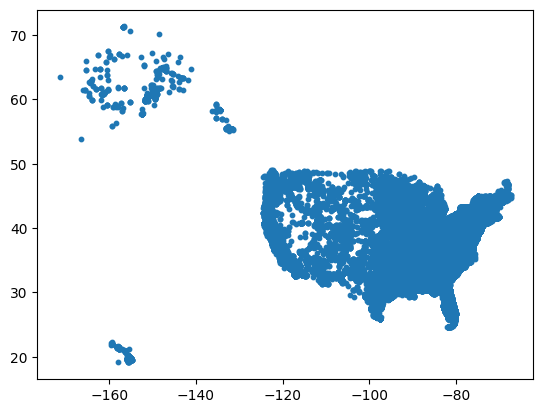

In [7]:
plt.scatter( numeric_dataset['longitude'], numeric_dataset['latitude'], s=10)

## 1.2 Outlier detection

## 1.3 Scaling

In [8]:
scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(numeric_dataset.values)
scaled_dataset.shape

(239381, 20)

# 2. K Means

## 2.1 Identification of the best value of k

In [9]:
sse_list = []
silhouette_list = []
davies_bouldin_list = []

max_k = 40
for k in tqdm(range(2, max_k + 1), ):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(scaled_dataset)

    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(scaled_dataset, kmeans.labels_, sample_size=10000))
    davies_bouldin_list.append(davies_bouldin_score(scaled_dataset, kmeans.labels_))

  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [04:03<00:00,  6.24s/it]


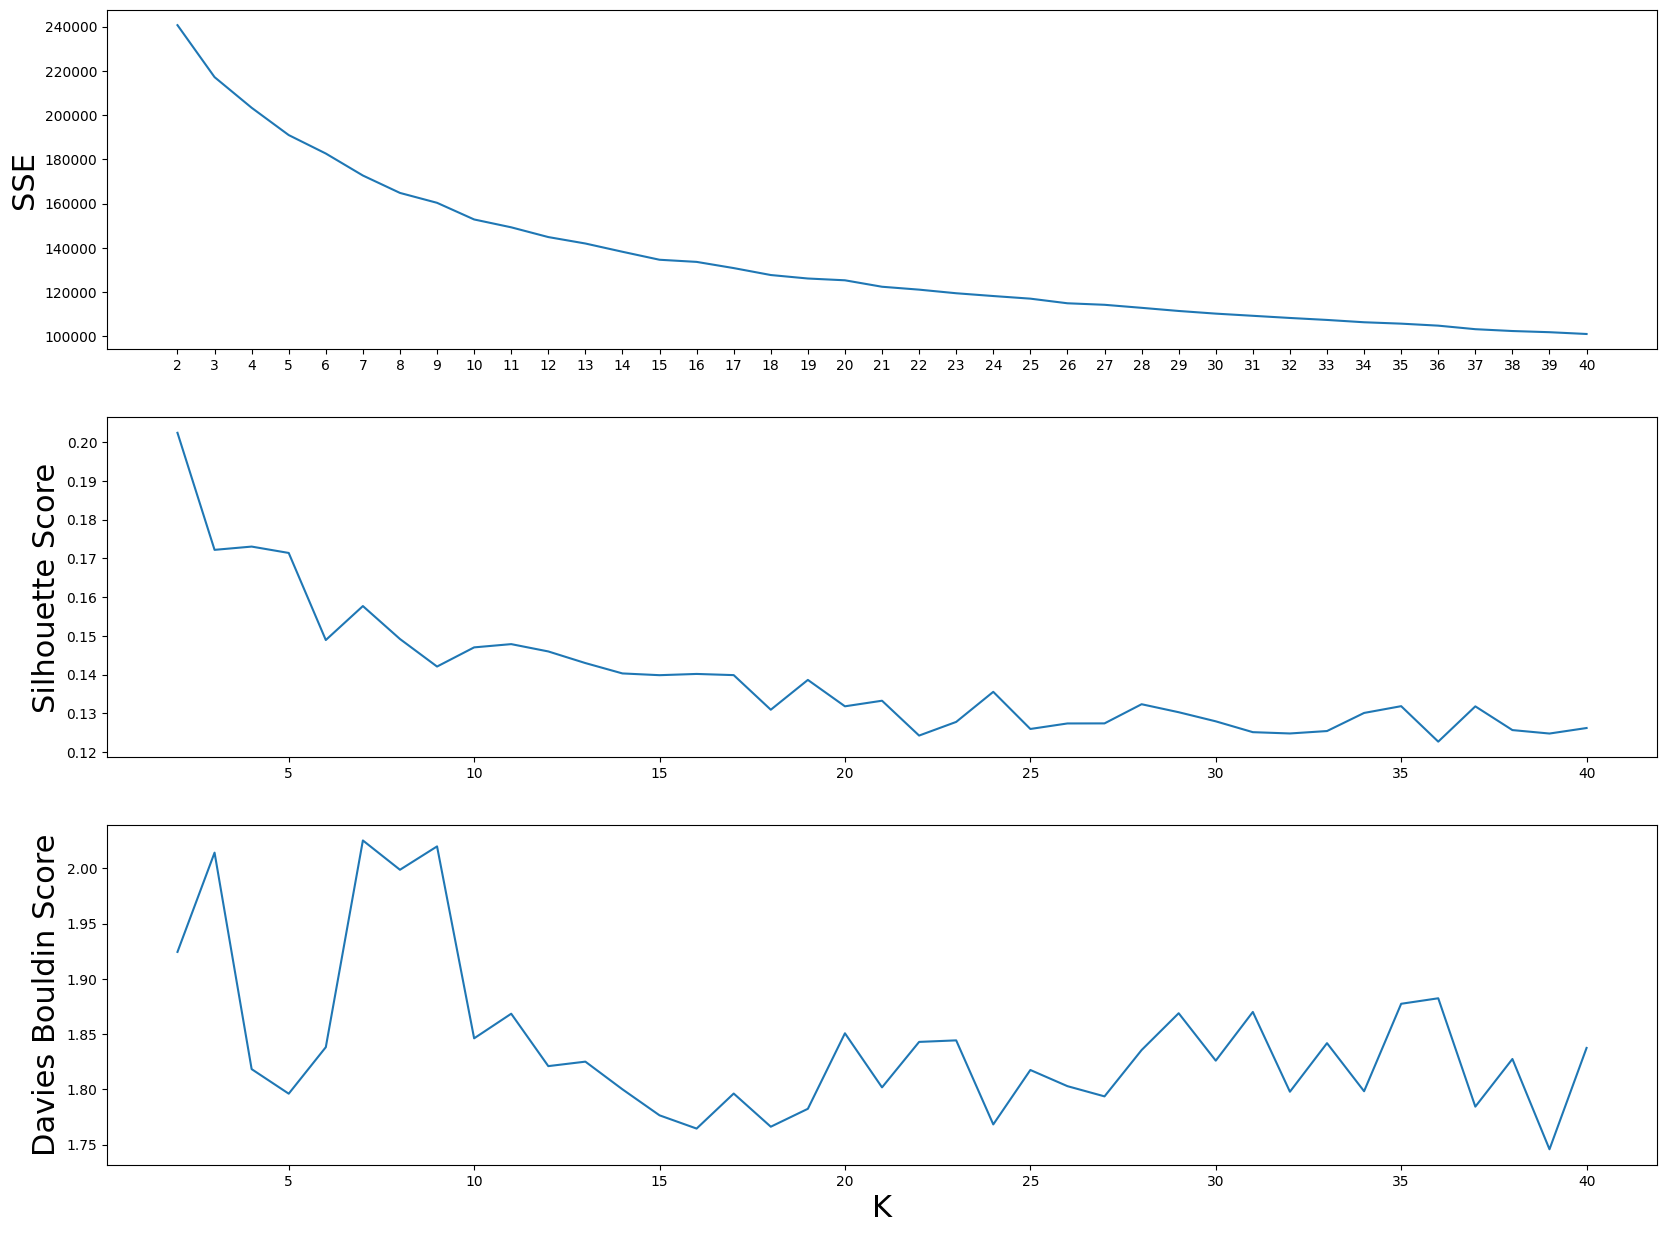

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list) + 2), sse_list)
ax[0].set_ylabel('SSE', fontsize=22)
ax[0].set_xticks(range(2, len(sse_list) + 2))

ax[1].plot(range(2, len(silhouette_list) + 2), silhouette_list)
ax[1].set_ylabel('Silhouette Score', fontsize=22)
ax[0].set_xticks(range(2, len(silhouette_list) + 2))

ax[2].plot(range(2, len(davies_bouldin_list) + 2), davies_bouldin_list)
ax[2].set_ylabel('Davies Bouldin Score', fontsize=22)
ax[0].set_xticks(range(2, len(davies_bouldin_list) + 2))


plt.xlabel('K', fontsize=22)
plt.show()

# NICER PLOTS

## 2.2 Analysis of the centroids and clusters

In [12]:
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(scaled_dataset)

KMeans(n_clusters=7, n_init=10)

In [13]:
print("Shape of scaled_dataset: ", scaled_dataset.shape)
print("Shape of kmeans.labels_: ", kmeans.labels_.shape)
print("Shape of kmeans.cluster_centers_: ", kmeans.cluster_centers_.shape)

Shape of scaled_dataset:  (239381, 20)
Shape of kmeans.labels_:  (239381,)
Shape of kmeans.cluster_centers_:  (7, 20)


In [14]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=numeric_dataset.columns)
centers_df.head(7)

,year,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,povertyPercentage,party,votes_ratio,totalvotes,population,month_x,month_y
0,2015.557722,36.557662,-89.725962,29.703639,31.634684,33.667816,0.015698,0.907290,0.832651,0.144436,0.237607,0.299534,1.878323,13.438829,1.000000e+00,0.656034,247351.817627,1.061610e+07,0.194931,-0.811292
1,2015.738908,37.269927,-91.532759,30.223039,32.096131,34.007914,0.011957,0.955497,0.887388,0.794214,0.042276,0.092721,1.563354,12.521457,1.387779e-14,0.713415,228316.499640,1.441874e+07,0.000698,0.010557
2,2015.756026,38.333492,-87.860232,27.810469,29.283767,30.856807,0.008018,0.915913,0.855434,0.007749,0.846812,0.047519,1.627005,12.175935,7.494005e-15,0.718430,239186.119774,1.250643e+07,-0.018862,-0.039372
3,2015.819033,37.801695,-88.551891,17.946127,18.769721,19.826819,0.877184,0.056902,0.867134,0.109708,0.425377,0.285907,1.743767,12.457483,3.473063e-01,0.690695,246674.851593,1.191833e+07,0.021112,0.022257
4,2015.683701,38.644931,-89.051764,28.254904,29.869827,31.709800,0.013079,0.888933,0.848643,0.022780,0.035734,0.440486,2.071957,12.103411,-1.121325e-14,0.683046,243127.366665,1.220244e+07,0.029046,-0.007521
5,2015.525807,36.767801,-89.584315,29.647799,31.562737,33.618493,0.016400,0.896774,0.825577,0.145222,0.239136,0.289944,1.887045,13.406486,1.000000e+00,0.657056,247710.145901,1.018137e+07,-0.814610,0.200217
6,2015.948111,36.486752,-89.929068,29.601960,31.503476,33.526686,0.015937,0.911890,0.835122,0.153790,0.234973,0.334201,1.824292,13.306108,1.000000e+00,0.651386,253246.718915,1.080302e+07,0.607520,0.578735


In [15]:
cluster_num_points = []
cluster_points = []
for i in range(n_clusters):
    cluster_points.append(scaled_dataset[kmeans.labels_ == i])
    cluster_num_points.append(len(cluster_points[-1]))
    
cluster_num_points, cluster_points[0].shape

([31600, 25019, 48123, 12714, 55672, 31871, 34382], (31600, 20))

In [16]:
kmeans_tot = KMeans(n_clusters=1, n_init=10)
kmeans_tot.fit(scaled_dataset)
total_SSE = kmeans_tot.inertia_ / len(scaled_dataset)

cluster_SSE = []
for i in range(n_clusters):
    cluster_sse = 0
    for point in cluster_points[i]:
        cluster_sse += np.linalg.norm(point - kmeans.cluster_centers_[i])**2
    cluster_SSE.append(cluster_sse / cluster_num_points[i])

print("Cluster SSE: ", cluster_SSE)
print("Total SSE: ", total_SSE)
print("SSE of cluster with min SSE: ", min(cluster_SSE))
print("SSE of cluster with max SSE: ", max(cluster_SSE))
print("Mean of SSE: ", np.mean(cluster_SSE))

Cluster SSE:  [0.709099386156205, 0.7152018363085775, 0.6829993586160957, 1.13291201834831, 0.7212917378993599, 0.7099192305545474, 0.7291757821646272]
Total SSE:  1.2565201122650995
SSE of cluster with min SSE:  0.6829993586160957
SSE of cluster with max SSE:  1.13291201834831
Mean of SSE:  0.7715141928639603


In [17]:
cluster_distance_variance = []
total_distance_variance = 0
dataset_centroid = np.mean(scaled_dataset, axis=0)

###### CI RIPENSIAMO SU QUESTO ######
for point in scaled_dataset:
    total_distance_variance += (np.linalg.norm(point - dataset_centroid)**2 - total_SSE) ** 2
total_distance_variance /= len(scaled_dataset)
#####################################

for i in range(n_clusters):
    variance = 0
    for p in cluster_points[i]:
        variance += ((np.linalg.norm(p - kmeans.cluster_centers_[i]))**2 - cluster_SSE[i])**2
    cluster_distance_variance.append(variance/cluster_num_points[i])

print("Cluster distance variance: ", cluster_distance_variance)
print("Total distance variance: ", total_distance_variance)
print("Distance variance of cluster with min SSE: ", min(cluster_distance_variance))
print("Distance variance of cluster with max SSE: ", max(cluster_distance_variance))
print("Mean of distance variance: ", np.mean(cluster_distance_variance))

Cluster distance variance:  [0.14726248110734036, 0.07811668239495252, 0.09776228629682632, 0.12978784787829234, 0.10146184212052278, 0.14859202492362078, 0.15447551595852854]
Total distance variance:  0.24499321848118627
Distance variance of cluster with min SSE:  0.07811668239495252
Distance variance of cluster with max SSE:  0.15447551595852854
Mean of distance variance:  0.12249409724001195


Analysis of distribution of repubblican vs democrats in the clusters.

In [18]:
party_xt_pct = pd.crosstab(kmeans.labels_, numeric_dataset['party'])
party_xt_pct

party,0,1
row_0,,
0,0,31600
1,25019,0
2,48123,0
3,8299,4415
4,55672,0
5,0,31871
6,0,34382


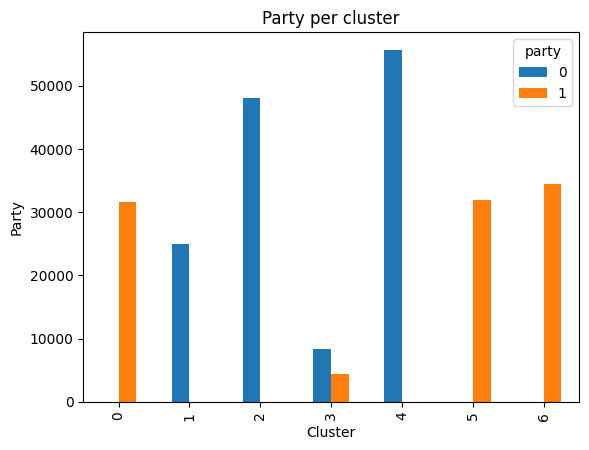

In [31]:
party_xt_pct.plot(kind='bar', stacked=False, 
                   title='Party per cluster')
plt.xlabel('Cluster')
plt.ylabel('Party')
plt.show()

Construct a distance matrix among cluster centroids.

<Axes: >

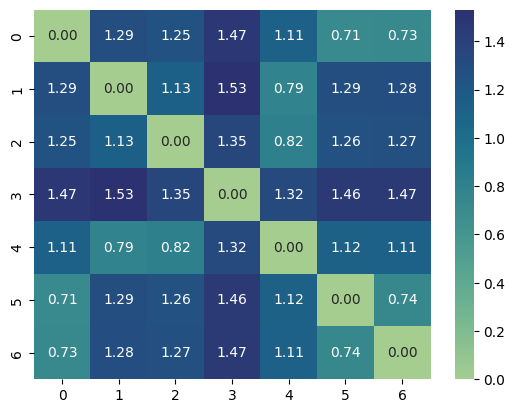

In [32]:
centroid_distance_matrix = squareform(pdist(kmeans.cluster_centers_))
sns.heatmap(centroid_distance_matrix, annot=True, fmt = '.2f', cmap='crest')

Construct matrix displaying correlation of attribute values to belonging to a certain cluster.

[]

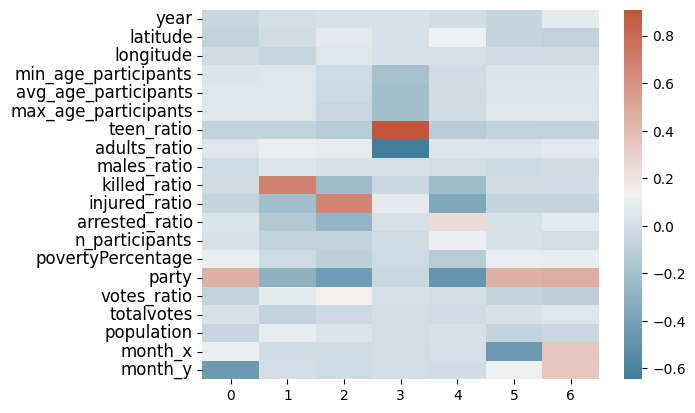

In [40]:
# Transfrom kmeans labels into onehot encoding
onehot = np.zeros((len(kmeans.labels_), n_clusters))
onehot[np.arange(len(kmeans.labels_)), kmeans.labels_] = 1

# Compute correlation between onehot encoding and scaled dataset
onehot_corr = np.corrcoef(scaled_dataset, onehot, rowvar=False)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(onehot_corr[:scaled_dataset.shape[1], scaled_dataset.shape[1]:], cmap=cmap)

# Set ticks on y axis with feature names
plt.yticks(np.arange(scaled_dataset.shape[1]) + 0.5, numeric_dataset.columns, rotation=0, fontsize=12)
[]

Compute the similarity matrix of a sample of the dataset.

([], [])

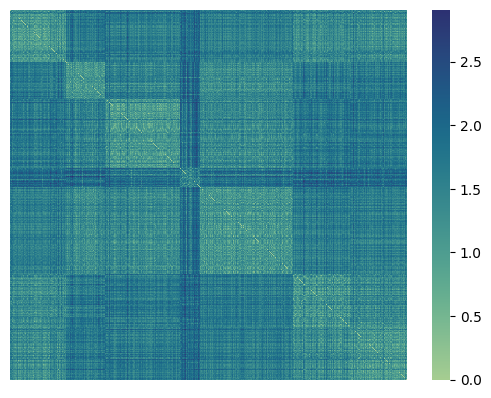

In [22]:
# Downsample the dataset to 10000
samples = np.random.choice(scaled_dataset.shape[0], 1000, replace=False)
downsampled_dataset = scaled_dataset[samples]
downsampled_labels = kmeans.labels_[samples]

# Sort based on labels
sorted_indexes = np.argsort(downsampled_labels)
downsampled_dataset = downsampled_dataset[sorted_indexes]
downsampled_labels = downsampled_labels[sorted_indexes]

# Compute similarity matrix
pdist_matrix = squareform(pdist(downsampled_dataset, metric='minkowski', p=2))
sns.heatmap(pdist_matrix, fmt = '.2f', cmap='crest')
plt.xticks([])
plt.yticks([])

In [23]:
kmeans.cluster_centers_.shape

(7, 20)

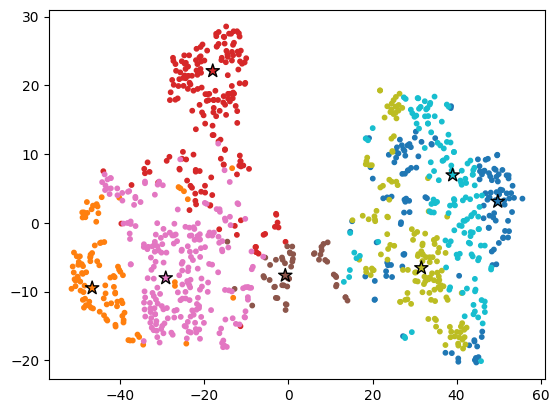

In [24]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_dataset = np.concatenate((downsampled_dataset, kmeans.cluster_centers_))
tsne_labels = np.concatenate((downsampled_labels, range(7)))
tsne_map = tsne.fit_transform(tsne_dataset)

plt.scatter(tsne_map[:-n_clusters, 0], tsne_map[:-n_clusters, 1], c = tsne_labels[:-n_clusters], s=10, cmap='tab10')
plt.scatter(tsne_map[-n_clusters:, 0], tsne_map[-n_clusters:, 1], c = tsne_labels[-n_clusters:], s=100, cmap='tab10', marker='*', edgecolors='black')


## 2.3 Distribution of variables: within clusters vs whole dataset

In [25]:
print(kmeans.labels_.shape)
print(numeric_dataset.shape)

(239381,)
(239381, 20)


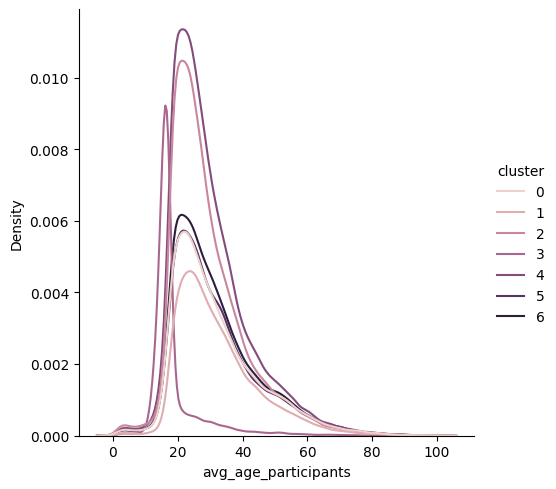

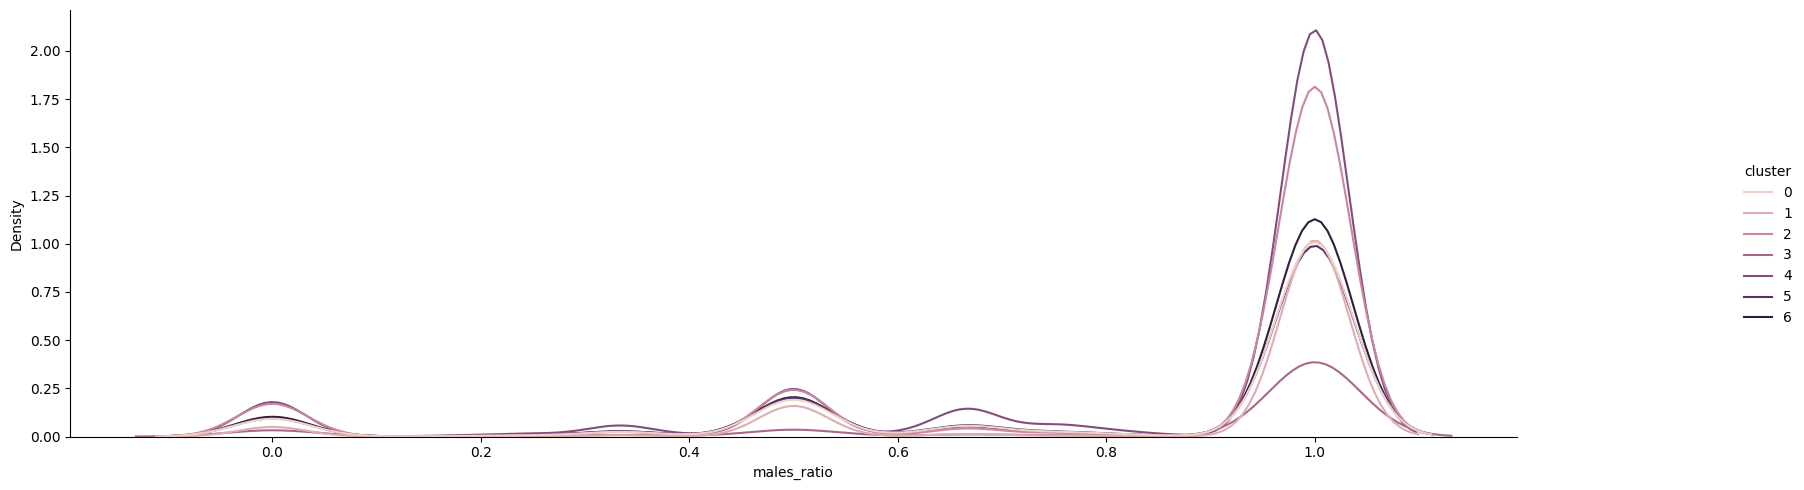

In [26]:
# Plot distribution of average age for whole dataset and clusters
numeric_dataset_with_clusters = numeric_dataset.copy()
numeric_dataset_with_clusters['cluster'] = kmeans.labels_

sns.displot(numeric_dataset_with_clusters, x="avg_age_participants", kind='kde', hue="cluster")

sns.displot(numeric_dataset_with_clusters, x="males_ratio", kind='kde', hue="cluster")

# Stretch horizontally
plt.gcf().set_size_inches(20, 5)


(0.0, 15.0)

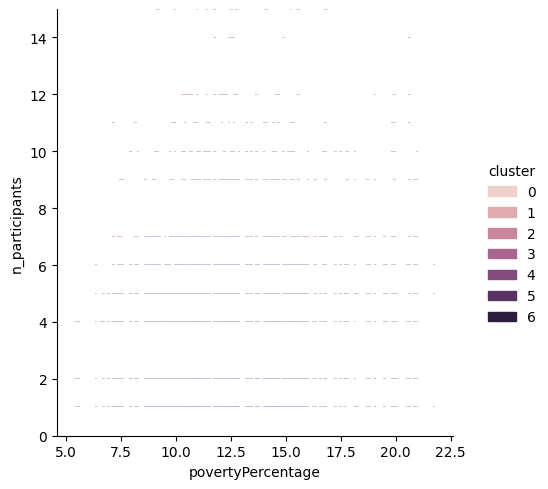

In [42]:
sns.displot(numeric_dataset_with_clusters, x="povertyPercentage", y='n_participants', hue="cluster")
plt.ylim(0,15)

(0.0, 8.0)

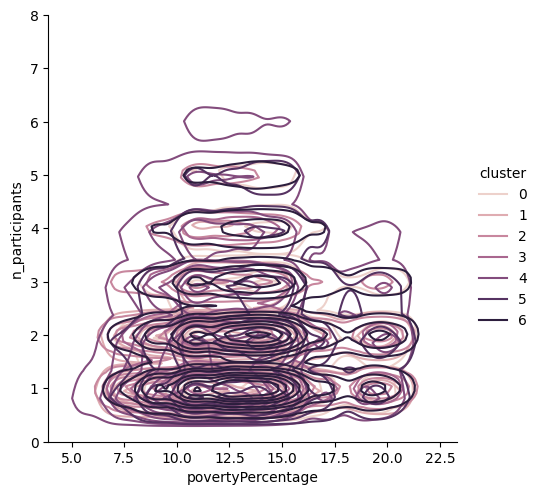

In [43]:
sns.displot(numeric_dataset_with_clusters, x="povertyPercentage", y='n_participants', kind='kde', hue="cluster")
# Restric the plot to number of participants between 0 and 30
plt.ylim(0, 8)

In [29]:
print(numeric_dataset.shape)

(239381, 20)


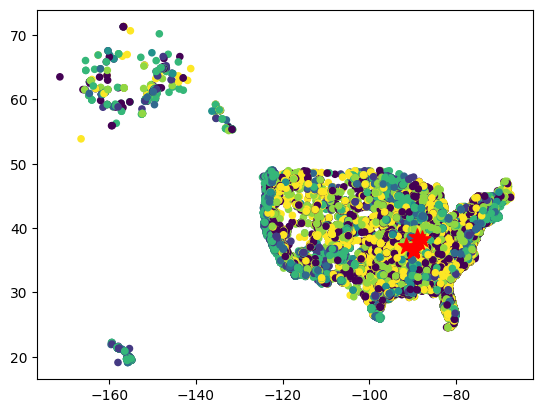

In [30]:
plt.scatter(numeric_dataset['longitude'], numeric_dataset['latitude'],  c=kmeans.labels_, s=20)
plt.scatter(centers_df['longitude'], centers_df['latitude'], marker='*', c='r', s=150)
#plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

# Best Clustering Approach